Importing libraries...
✓ Libraries imported
Using device: cpu

Loading data...
✓ Train: 11 samples
✓ Val: 2 samples
✓ Test: 3 samples

Extracting features...
Feature matrix: (11, 912)
✓ Features normalized

🔄 Reshaping features into temporal sequences...
✓ Sequences created:
  Shape: (11, 10, 91)
  Interpretation: [samples, 10 time_steps, 91 features_per_step]
✓ Dataloaders created (batch_size=4)
✓ Temporal LSTM created

Model architecture:
TemporalLSTM(
  (lstm): LSTM(91, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

Parameters: 638,338
✓ Training setup complete
✓ Training functions defined

TRAINING TEMPORAL LSTM

⏰ Processing sequences over time...
This captures how features change during the interview

Epoch 5/50
  Train MAE: 5.90

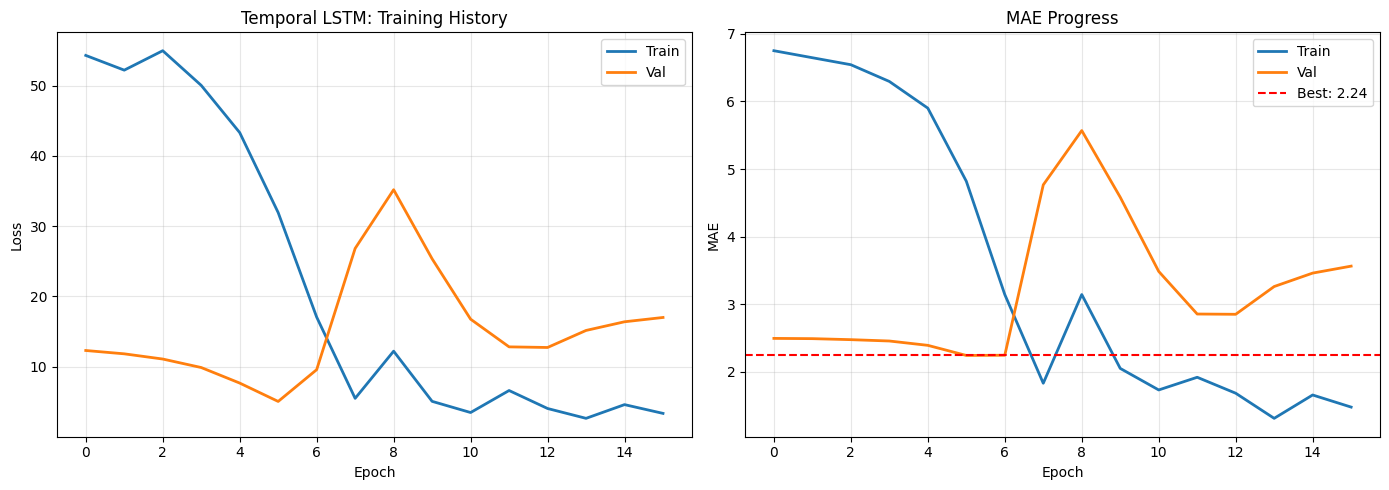


FINAL EVALUATION

📊 Validation:
  MAE: 2.2429
  R²: 0.1942

📊 Test:
  MAE: 7.5356
  RMSE: 10.1201
  R²: -0.8289

COMPARISON WITH FUSION METHODS

📊 Test MAE Comparison:
  Early Fusion: 9.9444
  Late Fusion (best): 6.4185
  Temporal LSTM: 7.5356


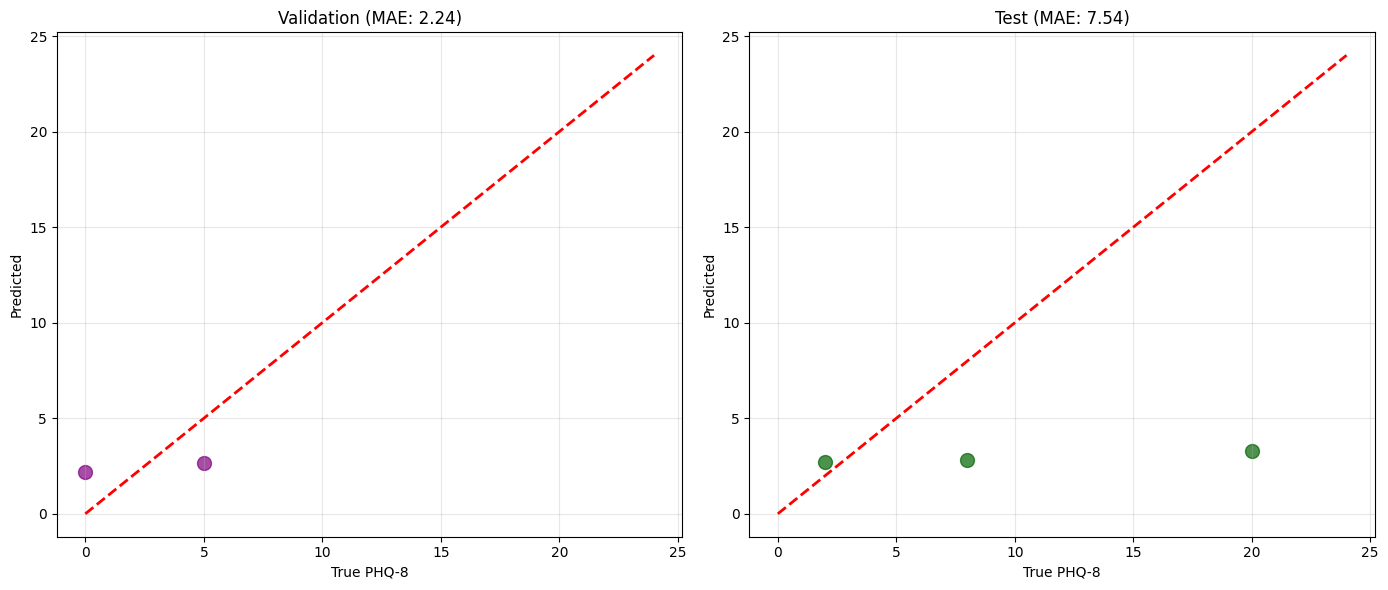


✓ Results saved

✅ TEMPORAL LSTM COMPLETE!

📊 Results:
  Test MAE: 7.5356
  Test R²: -0.8289

💡 Key Innovation:
  - Processes features as sequences over time
  - Bidirectional LSTM captures temporal patterns
  - Attention weights important time steps

🎯 Next: Notebook 14 for attention visualization


In [1]:
"""
NOTEBOOK 13: Temporal LSTM - Processing Sequences Over Time

SAVE AS: notebooks/modeling/07_temporal_lstm.ipynb

WHAT THIS DOES:
- Reshapes features into sequences (pseudo-temporal)
- Uses bidirectional LSTM to capture temporal dynamics
- Models how features change over the interview
- Compares with non-temporal fusion

TIME: 20-30 minutes
"""

# ========== CELL 1: Import Libraries ==========
print("Importing libraries...")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========== CELL 2: Load Data ==========
print("\nLoading data...")

PROCESSED_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\data\processed')
MODELS_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\models\saved_models')
RESULTS_DIR = Path(r'C:\Users\VIJAY BHUSHAN SINGH\depression_detection_project\results')

MODELS_DIR.mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / 'figures').mkdir(parents=True, exist_ok=True)

train_df = pd.read_csv(PROCESSED_DIR / 'train_data.csv')
val_df = pd.read_csv(PROCESSED_DIR / 'val_data.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'test_data.csv')

print(f"✓ Train: {len(train_df)} samples")
print(f"✓ Val: {len(val_df)} samples")
print(f"✓ Test: {len(test_df)} samples")

# ========== CELL 3: Extract All Features ==========
print("\nExtracting features...")

# Get all feature columns
feature_cols = [col for col in train_df.columns if col not in 
                ['session_id', 'PHQ8_Score', 'severity_class', 'severity_name']]

X_train = train_df[feature_cols].values
y_train = train_df['PHQ8_Score'].values

X_val = val_df[feature_cols].values
y_val = val_df['PHQ8_Score'].values

X_test = test_df[feature_cols].values
y_test = test_df['PHQ8_Score'].values

print(f"Feature matrix: {X_train.shape}")

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("✓ Features normalized")

# ========== CELL 4: Reshape into Sequences ==========
print("\n🔄 Reshaping features into temporal sequences...")

def create_sequences(X, seq_length=10):
    """
    Reshape features into sequences
    
    Strategy: Split feature vector into seq_length chunks
    This creates pseudo-temporal sequences
    
    Args:
        X: [batch, features]
        seq_length: Number of time steps
        
    Returns:
        X_seq: [batch, seq_length, features_per_step]
    """
    n_samples, n_features = X.shape
    
    # Calculate features per time step
    features_per_step = n_features // seq_length
    
    # Truncate to fit evenly
    n_features_used = features_per_step * seq_length
    X_truncated = X[:, :n_features_used]
    
    # Reshape: [batch, seq_length, features_per_step]
    X_seq = X_truncated.reshape(n_samples, seq_length, features_per_step)
    
    return X_seq, features_per_step

# Create sequences
seq_length = 10  # Treat as 10 time steps
X_train_seq, feat_per_step = create_sequences(X_train, seq_length)
X_val_seq, _ = create_sequences(X_val, seq_length)
X_test_seq, _ = create_sequences(X_test, seq_length)

print(f"✓ Sequences created:")
print(f"  Shape: {X_train_seq.shape}")
print(f"  Interpretation: [samples, {seq_length} time_steps, {feat_per_step} features_per_step]")

# ========== CELL 5: Create Dataset ==========
class TemporalDataset(Dataset):
    """Dataset for temporal sequences"""
    
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TemporalDataset(X_train_seq, y_train)
val_dataset = TemporalDataset(X_val_seq, y_val)
test_dataset = TemporalDataset(X_test_seq, y_test)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✓ Dataloaders created (batch_size={batch_size})")

# ========== CELL 6: Define Temporal LSTM Model ==========

class TemporalLSTM(nn.Module):
    """
    Bidirectional LSTM for temporal sequences
    
    Key idea: Process the sequence in both directions
    - Forward: Captures how depression develops during interview
    - Backward: Captures patterns from end to start
    """
    
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(TemporalLSTM, self).__init__()
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # KEY: Process both directions
        )
        
        # Attention mechanism (simple version)
        self.attention = nn.Linear(hidden_size * 2, 1)  # *2 for bidirectional
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Output layers
        self.fc1 = nn.Linear(hidden_size * 2, 64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        # x shape: [batch, seq_length, features]
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # [batch, seq, hidden*2]
        
        # Simple attention: weight each time step
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # [batch, seq, 1]
        
        # Weighted sum of LSTM outputs
        context = torch.sum(attention_weights * lstm_out, dim=1)  # [batch, hidden*2]
        
        # Dropout
        context = self.dropout(context)
        
        # Final prediction
        out = torch.relu(self.fc1(context))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out.squeeze()

# Create model
model = TemporalLSTM(
    input_size=feat_per_step,
    hidden_size=128,
    num_layers=2,
    dropout=0.3
)
model = model.to(device)

print(f"✓ Temporal LSTM created")
print(f"\nModel architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nParameters: {total_params:,}")

# ========== CELL 7: Training Setup ==========
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

print("✓ Training setup complete")

# ========== CELL 8: Training Functions ==========
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend(outputs.detach().cpu().numpy())
        targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    mae = mean_absolute_error(targets, predictions)
    
    return avg_loss, mae

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    r2 = r2_score(targets, predictions)
    
    return avg_loss, mae, rmse, r2, predictions, targets

print("✓ Training functions defined")

# ========== CELL 9: Train Model ==========
print("\n" + "="*60)
print("TRAINING TEMPORAL LSTM")
print("="*60)
print("\n⏰ Processing sequences over time...")
print("This captures how features change during the interview\n")

num_epochs = 50
best_val_mae = float('inf')
patience = 10
patience_counter = 0

train_losses = []
val_losses = []
train_maes = []
val_maes = []

for epoch in range(num_epochs):
    train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_mae, val_rmse, val_r2, _, _ = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    
    scheduler.step(val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train MAE: {train_mae:.4f}")
        print(f"  Val MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
    
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), MODELS_DIR / 'temporal_lstm_best.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n✓ Training complete! Best val MAE: {best_val_mae:.4f}")

# ========== CELL 10: Plot Training ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(val_losses, label='Val', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Temporal LSTM: Training History')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(train_maes, label='Train', linewidth=2)
axes[1].plot(val_maes, label='Val', linewidth=2)
axes[1].axhline(y=best_val_mae, color='r', linestyle='--', label=f'Best: {best_val_mae:.2f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE Progress')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'temporal_lstm_training.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== CELL 11: Final Evaluation ==========
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

model.load_state_dict(torch.load(MODELS_DIR / 'temporal_lstm_best.pth'))

val_loss, val_mae, val_rmse, val_r2, val_preds, val_targets = evaluate(model, val_loader, criterion, device)
test_loss, test_mae, test_rmse, test_r2, test_preds, test_targets = evaluate(model, test_loader, criterion, device)

print(f"\n📊 Validation:")
print(f"  MAE: {val_mae:.4f}")
print(f"  R²: {val_r2:.4f}")

print(f"\n📊 Test:")
print(f"  MAE: {test_mae:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  R²: {test_r2:.4f}")

# ========== CELL 12: Compare with Fusion Methods ==========
print("\n" + "="*60)
print("COMPARISON WITH FUSION METHODS")
print("="*60)

try:
    early_df = pd.read_csv(RESULTS_DIR / 'metrics' / 'early_fusion_results.csv')
    late_df = pd.read_csv(RESULTS_DIR / 'metrics' / 'late_fusion_results.csv')
    
    early_mae = early_df['test_mae'].values[0]
    late_mae_best = late_df['test_mae'].min()
    
    print(f"\n📊 Test MAE Comparison:")
    print(f"  Early Fusion: {early_mae:.4f}")
    print(f"  Late Fusion (best): {late_mae_best:.4f}")
    print(f"  Temporal LSTM: {test_mae:.4f}")
    
    if test_mae < min(early_mae, late_mae_best):
        improvement = ((min(early_mae, late_mae_best) - test_mae) / min(early_mae, late_mae_best)) * 100
        print(f"\n🎯 Temporal LSTM improves by {improvement:.1f}%!")
    
except:
    print("\n⚠ Previous results not found")

# ========== CELL 13: Visualize ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(val_targets, val_preds, alpha=0.7, s=100, color='purple')
axes[0].plot([0, 24], [0, 24], 'r--', linewidth=2)
axes[0].set_xlabel('True PHQ-8')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Validation (MAE: {val_mae:.2f})')
axes[0].grid(alpha=0.3)

axes[1].scatter(test_targets, test_preds, alpha=0.7, s=100, color='darkgreen')
axes[1].plot([0, 24], [0, 24], 'r--', linewidth=2)
axes[1].set_xlabel('True PHQ-8')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Test (MAE: {test_mae:.2f})')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'temporal_lstm_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# ========== CELL 14: Save Results ==========
results = {
    'model': 'Temporal LSTM',
    'method': 'bidirectional_lstm',
    'val_mae': val_mae,
    'val_r2': val_r2,
    'test_mae': test_mae,
    'test_rmse': test_rmse,
    'test_r2': test_r2
}

results_df = pd.DataFrame([results])
results_df.to_csv(RESULTS_DIR / 'metrics' / 'temporal_lstm_results.csv', index=False)

print(f"\n✓ Results saved")

# ========== CELL 15: Summary ==========
print("\n" + "="*60)
print("✅ TEMPORAL LSTM COMPLETE!")
print("="*60)

print(f"\n📊 Results:")
print(f"  Test MAE: {test_mae:.4f}")
print(f"  Test R²: {test_r2:.4f}")

print(f"\n💡 Key Innovation:")
print(f"  - Processes features as sequences over time")
print(f"  - Bidirectional LSTM captures temporal patterns")
print(f"  - Attention weights important time steps")

print(f"\n🎯 Next: Notebook 14 for attention visualization")
print("="*60)